In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Conv2DTranspose, AveragePooling2D, Add, Reshape
from scipy.interpolate import RectBivariateSpline
try:
    import tensorflow.contrib.eager as tfe
    opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.95)
    conf = tf.ConfigProto(gpu_options=opts)
    tfe.enable_eager_execution(config=conf)
except:
    pass
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Boundary import Boundary1D
from MergeWithAttention import MergeWithAttention2
from Upsample import Upsample
from collections.abc import Iterable
import itertools, h5py
from multiprocessing import Pool as ThreadPool
from Lp_integral_norm import Lp_integral_norm
tf.keras.backend.set_floatx('float64')

In [2]:
ntest = 64
h = 0.05
folder = 'dataset_' + str(ntest)
boundary_top = Boundary1D('Dirichlet', [(0,ntest*h),(ntest*h,ntest*h)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)
boundary_right = Boundary1D('Dirichlet', [(ntest*h,ntest*h),(ntest*h,0)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)
boundary_bottom = Boundary1D('Dirichlet', [(ntest*h,0),(0,0)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)
boundary_left = Boundary1D('Dirichlet', [(0,0),(0,ntest*h)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)

In [3]:
for i in range(0,3):
    with h5py.File(folder + '/range_-1_1/dataset' + str(i) + '_-11.h5', 'r') as hf:
        F = np.array(hf.get('F'), dtype = np.float64)
        soln = np.array(hf.get('soln'), dtype = np.float64)
        try:
            train_data = train_data.concatenate(tf.data.Dataset.from_tensor_slices((F,soln)))
        except:
            train_data = tf.data.Dataset.from_tensor_slices((F,soln))
for i in range(0,3):
    with h5py.File(folder + '/range_-1_1/analyticdataset' + str(i) + '_-11.h5', 'r') as hf:
        F = np.array(hf.get('F'), dtype = np.float64)
        soln = np.array(hf.get('soln'), dtype = np.float64)
        try:
            train_data = train_data.concatenate(tf.data.Dataset.from_tensor_slices((F,soln)))
        except:
            train_data = tf.data.Dataset.from_tensor_slices((F,soln))

In [4]:
for i in range(5,6):
    with h5py.File(folder + '/range_-1_1/dataset' + str(i) + '_-11.h5', 'r') as hf:
        F = np.array(hf.get('F'), dtype = np.float64)
        soln = np.array(hf.get('soln'), dtype = np.float64)
        try:
            valid_data = valid_data.concatenate(tf.data.Dataset.from_tensor_slices((F,soln)))
        except:
            valid_data = tf.data.Dataset.from_tensor_slices((F,soln))
            
for i in range(5,6):
    with h5py.File(folder + '/range_-1_1/analyticdataset' + str(i) + '_-11.h5', 'r') as hf:
        F = np.array(hf.get('F'), dtype = np.float64)
        soln = np.array(hf.get('soln'), dtype = np.float64)
        try:
            valid_data = valid_data.concatenate(tf.data.Dataset.from_tensor_slices((F,soln)))
        except:
            valid_data = tf.data.Dataset.from_tensor_slices((F,soln))

In [ ]:
# with h5py.File('dataset' + str(8) + '.h5', 'r') as hf:
#         F_valid = np.array(hf.get('F'), dtype = np.float64)
#         soln_valid = np.array(hf.get('soln'), dtype = np.float64)

In [5]:
shuffle_size = 100000
batch_size = 200
train_data = train_data.shuffle(shuffle_size).batch(batch_size)
valid_data = valid_data.shuffle(shuffle_size).batch(batch_size)
del F, soln

In [6]:
#stable model
input_0 = Input(shape=(1,ntest,ntest,))
conv_1_0 = Conv2D(filters = 5, kernel_size = 3, activation=tf.nn.leaky_relu, data_format='channels_first', padding='same')(input_0)

conv_2_0 = Conv2D(filters = 16, kernel_size = 3, activation=tf.nn.leaky_relu, data_format='channels_first', padding='same')(conv_1_0)
pool_2_0 = AveragePooling2D(data_format = 'channels_first')(conv_2_0)
pool_2_1 = AveragePooling2D(data_format = 'channels_first')(pool_2_0)
pool_2_2 = AveragePooling2D(data_format = 'channels_first')(pool_2_1)
pool_2_3 = AveragePooling2D(data_format = 'channels_first')(pool_2_2)
pool_2_4 = AveragePooling2D(data_format = 'channels_first')(pool_2_3)
pool_2_5 = AveragePooling2D(data_format = 'channels_first')(pool_2_4)
#pool_2_6 = AveragePooling2D(data_format = 'channels_first')(pool_2_5)

conv_3_0 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_2_0)
conv_3_1 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_0)
conv_3_2 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_1)
conv_3_3 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_2)
conv_3_4 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_3)
conv_3_5 = Conv2D(filters = 8, kernel_size = 1, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_4)
conv_3_6 = Conv2D(filters = 8, kernel_size = 1, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_5)
#conv_3_7 = Conv2D(filters = 8, kernel_size = 1, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_6)

upsample_3_1 = Upsample(resize_method=tf.image.ResizeMethod.BICUBIC)(conv_3_1)
upsample_3_2 = Upsample(4, resize_method=tf.image.ResizeMethod.BICUBIC)(conv_3_2)
upsample_3_3 = Upsample(8, resize_method=tf.image.ResizeMethod.BICUBIC)(conv_3_3)
upsample_3_4 = Upsample(16, resize_method=tf.image.ResizeMethod.BICUBIC)(conv_3_4)
#upsample_3_1 = Upsample(resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_1)
#upsample_3_2 = Upsample(4, resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_2)
#upsample_3_3 = Upsample(8, resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_3)
#upsample_3_4 = Upsample(16, resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_4)
upsample_3_5 = Upsample(32, resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_5)
upsample_3_6 = Upsample(64, resize_method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)(conv_3_6)
#upsample_3_7 = Upsample(128, resize_method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)(conv_3_7)

conv_4_0 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_3_0)
conv_4_1 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_1)
conv_4_2 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_2)
conv_4_3 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_3)
conv_4_4 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_4)
conv_4_5 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_5)
#conv_4_6 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_6)

#merge_4_0 = MergeWithAttention2()([conv_4_0, conv_4_1, conv_4_2, conv_4_3, conv_4_4, conv_4_5, conv_4_6, upsample_3_7])
merge_4_0 = MergeWithAttention2()([conv_4_0, conv_4_1, conv_4_2, conv_4_3, conv_4_4, conv_4_5, upsample_3_6])#, upsample_3_7])

conv_5_0 = Conv2D(filters = 16, kernel_size = 3, activation = tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(merge_4_0)

conv_5_1 = Conv2D(filters = 5, kernel_size = 3, activation = tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_5_0)
#final_activation = tf.keras.layers.PReLU()(conv_5_1)
conv_6_0 = Conv2D(filters = 1, kernel_size = 3, activation='linear', data_format = 'channels_first', padding='same')(conv_5_1)#(final_activation)

a = Model(input_0, conv_6_0)
#a.load_weights(folder + '/model_stable.h5') - for [0,1]# - 1.3% mae
#a.load_weights(folder + '/model_stable_-11.h5')# - 4% mae
#a.load_weights(folder + '/model_stable_analyticaugmented_-11.h5')
a.load_weights(folder + '/modelbicubic_stable_analyticaugmented_-11.h5')

In [7]:
#how to train this - start with lr = 1e-2, switch to lr = 1e-4/1e-5 later on, keep mse component to 1e+1. use large no. of steps per epoch.
a.compile(optimizer = tf.train.AdamOptimizer(learning_rate=5e-6), loss = Lp_integral_norm((ntest,ntest), [0,ntest*h,0,ntest*h], n_quadpts=20, quadpts_randomization=2, p=2, mse_component_weight = 1e+2), metrics = ['mse','mae'])
#a.compile(optimizer = tf.train.AdamOptimizer(learning_rate=1e-2), loss = 'mse', metrics = ['mae'])

#a.summary()

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'AdamOptimizer'

In [8]:
from IPython.display import clear_output
for i in range(1):
#while True:
    a.fit(train_data, steps_per_epoch=60, epochs=20, validation_data=valid_data, validation_steps=2)
    clear_output(wait=True)

Epoch 1/20
60/60 [==============================] - 72s 1s/step - loss: 0.0152 - mean_squared_error: 2.0352e-05 - mean_absolute_error: 0.0032 - val_loss: 0.0137 - val_mean_squared_error: 1.6326e-05 - val_mean_absolute_error: 0.0030
Epoch 2/20
60/60 [==============================] - 57s 955ms/step - loss: 0.0148 - mean_squared_error: 1.9327e-05 - mean_absolute_error: 0.0032 - val_loss: 0.0140 - val_mean_squared_error: 1.7419e-05 - val_mean_absolute_error: 0.0031
Epoch 3/20
60/60 [==============================] - 61s 1s/step - loss: 0.0144 - mean_squared_error: 1.8394e-05 - mean_absolute_error: 0.0031 - val_loss: 0.0133 - val_mean_squared_error: 1.5910e-05 - val_mean_absolute_error: 0.0029
Epoch 4/20
60/60 [==============================] - 61s 1s/step - loss: 0.0140 - mean_squared_error: 1.7537e-05 - mean_absolute_error: 0.0030 - val_loss: 0.0133 - val_mean_squared_error: 1.6559e-05 - val_mean_absolute_error: 0.0029
Epoch 5/20
60/60 [==============================] - 61s 1s/step - los

In [24]:
a.save_weights(folder + '/modelbicubic_stable_analyticaugmented_-11.h5')

In [6]:
#testing model
input_0 = Input(shape=(1,ntest,ntest,))
conv_1_0 = Conv2D(filters = 5, kernel_size = 3, activation=tf.nn.leaky_relu, data_format='channels_first', padding='same')(input_0)

conv_2_0 = Conv2D(filters = 16, kernel_size = 3, activation=tf.nn.leaky_relu, data_format='channels_first', padding='same')(conv_1_0)
pool_2_0 = AveragePooling2D(data_format = 'channels_first')(conv_2_0)
pool_2_1 = AveragePooling2D(data_format = 'channels_first')(pool_2_0)
pool_2_2 = AveragePooling2D(data_format = 'channels_first')(pool_2_1)
pool_2_3 = AveragePooling2D(data_format = 'channels_first')(pool_2_2)
pool_2_4 = AveragePooling2D(data_format = 'channels_first')(pool_2_3)
pool_2_5 = AveragePooling2D(data_format = 'channels_first')(pool_2_4)
pool_2_6 = AveragePooling2D(data_format = 'channels_first')(pool_2_5)

conv_3_0 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_2_0)
conv_3_1 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_0)
conv_3_2 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_1)
conv_3_3 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_2)
conv_3_4 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_3)
conv_3_5 = Conv2D(filters = 8, kernel_size = 1, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_4)
conv_3_6 = Conv2D(filters = 8, kernel_size = 1, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_5)
#conv_3_7 = Conv2D(filters = 8, kernel_size = 1, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_6)

upsample_3_1 = Upsample(2, resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_1)
upsample_3_2 = Upsample(4, resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_2)
upsample_3_3 = Upsample(8, resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_3)
upsample_3_4 = Upsample(16, resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_4)
upsample_3_5 = Upsample(32, resize_method=tf.image.ResizeMethod.BILINEAR)(conv_3_5)
upsample_3_6 = Upsample(64, resize_method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)(conv_3_6)


conv_4_0 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_3_0)
conv_4_1 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_1)
conv_4_2 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_2)
conv_4_3 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_3)
conv_4_4 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_4)
conv_4_5 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_5)
#conv_4_6 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(upsample_3_6)


#merge_4_0 = MergeWithAttention2()([conv_4_0, conv_4_1, conv_4_2, conv_4_3, conv_4_4, conv_4_5, conv_4_6, upsample_3_7])
merge_4_0 = MergeWithAttention2()([conv_4_0, conv_4_1, conv_4_2, conv_4_3, conv_4_4, conv_4_5, upsample_3_6])#, upsample_3_7])

conv_5_0 = Conv2D(filters = 16, kernel_size = 3, activation = tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(merge_4_0)

conv_5_1 = Conv2D(filters = 5, kernel_size = 3, activation = tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_5_0)
#final_activation = tf.keras.layers.PReLU()(conv_5_1)
conv_6_0 = Conv2D(filters = 1, kernel_size = 3, activation='linear', data_format = 'channels_first', padding='same')(conv_5_1)

conv_7_0 = Conv2D(filters = 1, kernel_size = 1, activation=tf.nn.tanh, data_format = 'channels_first', padding = 'same')(conv_5_1)
prelu_7_0 = tf.keras.layers.PReLU()(conv_6_0)
merge_7_0 = tf.keras.layers.Multiply()([conv_7_0, prelu_7_0])

b = Model(input_0, merge_7_0)

In [62]:
b.compile(optimizer = tf.train.AdamOptimizer(learning_rate=5e-6), loss = Lp_integral_norm((64,64), domain = [0,ntest*h,0,ntest*h], n_quadpts = 20, quadpts_randomization = 2, mse_component_weight = 1e+1), metrics = ['mse','mae'])
#b.summary()

In [ ]:
from IPython.display import clear_output
while True:
    b.fit(train_data, steps_per_epoch=50, epochs=20, validation_data=valid_data, validation_steps=3)
    clear_output(wait = True)

In [59]:
b.save_weights(folder + '/model_test_prelutanh_-11.h5')

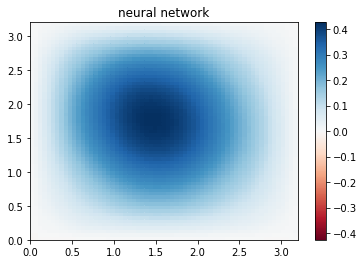

In [17]:
#plotting
# try:
#     p = valid_data.make_one_shot_iterator().get_next()
# except:
#     p = valid_data.__iter__().next()
#p = [rhses,solns]
#p_r = np.random.randint(0,batch_size)
y, x = np.meshgrid(np.linspace(0, ntest*h, ntest), np.linspace(0, ntest*h, ntest))
z = a.predict(tf.expand_dims(p[0][p_r,...], axis=0))[0,0,...]
#z = p[1][p_r,0,...]
#z = soln_chol[p_r,0,...]
#z = generate_random_RHS(10, n_controlpts=10, n_outputpts=64)[4,:,:]
#z = a.predict(tf.expand_dims(p[0][p_r,...], axis=0))[0,0,...] - p[1][p_r,0,...]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('neural network')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [8]:
#mean % error
tf.reduce_mean(tf.abs(a.predict(p[0][...]) - p[1][...]))/tf.reduce_mean(tf.abs(p[1][...]))

<tf.Tensor: id=3175, shape=(), dtype=float64, numpy=0.04554283009035297>

In [ ]:
#dummy model to test memory/compute time scaling when doing inference
ntest2 = 160
input_0 = Input(shape=(1,ntest2,ntest2,))
conv_1_0 = Conv2D(filters = 5, kernel_size = 3, activation=tf.nn.leaky_relu, data_format='channels_first', padding='same')(input_0)

conv_2_0 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format='channels_first', padding='same')(conv_1_0)
pool_2_0 = AveragePooling2D(data_format = 'channels_first')(conv_2_0)
pool_2_1 = AveragePooling2D(data_format = 'channels_first')(pool_2_0)
pool_2_2 = AveragePooling2D(data_format = 'channels_first')(pool_2_1)
pool_2_3 = AveragePooling2D(pool_size=(4,4), data_format = 'channels_first')(pool_2_2)

conv_3_0 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_2_0)
conv_3_1 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_0)
conv_3_2 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_1)
conv_3_3 = Conv2D(filters = 8, kernel_size = 3, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_2)
conv_3_4 = Conv2D(filters = 8, kernel_size = 1, activation=tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(pool_2_3)
upsample_3_1 = Upsample()(conv_3_1)
upsample_3_2 = Upsample(4)(conv_3_2)
upsample_3_3 = Upsample(8)(conv_3_3)
upsample_3_4 = Upsample(32)(conv_3_4)
merge_3_0 = Add()([conv_3_0, upsample_3_1, upsample_3_2, upsample_3_3, upsample_3_4])

conv_4_0 = Conv2D(filters = 8, kernel_size = 1, activation = tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(merge_3_0)

conv_5_0 = Conv2D(filters = 1, kernel_size = 1, activation = tf.nn.leaky_relu, data_format = 'channels_first', padding='same')(conv_4_0)
final_activation = tf.keras.layers.PReLU()(conv_5_0)
c = Model(input_0, final_activation)

In [ ]:
#neural network computation time
import time
g = tf.random.uniform((1,1,ntest2,ntest2),dtype=tf.float64)
t0 = time.time()
c.predict_on_batch(g)
t1 = time.time()
print(t1-t0)

In [ ]:
#Cholesky decomposition computation time (time taken to do the decomposition not incl.)
import time
f = np.random.rand(1,1,ntest,ntest)
lhs = tf.constant(poisson_matrix(ntest,ntest), dtype=tf.float64)
lhs_chol = tf.expand_dims(tf.linalg.cholesky(lhs), axis=0)
boundaries = {'top': boundary_top.RHS_evaluate(np.linspace(boundary_top.t.min(),boundary_top.t.max(),ntest)), 'right': boundary_right.RHS_evaluate(np.linspace(boundary_right.t.min(),boundary_right.t.max(),ntest)), 'bottom': boundary_bottom.RHS_evaluate(np.linspace(boundary_bottom.t.min(),boundary_bottom.t.max(),ntest)), 'left': boundary_left.RHS_evaluate(np.linspace(boundary_left.t.min(),boundary_left.t.max(),ntest))}
t0 = time.time()
rhs = tf.transpose(poisson_RHS((f,boundaries,h)),(0,2,1))
tf.linalg.cholesky_solve(lhs_chol, rhs)
t1 = time.time()
print(t1-t0)

In [ ]:
#successive overrelaxation
f = np.random.rand(1,1,ntest2,ntest2)
lhs = poisson_matrix(ntest2,ntest2)
L = np.tril(lhs, k=1)
D = np.diag(lhs) * np.eye(L.shape[0])
Dinv = (np.diag(lhs)**-1) * np.eye(L.shape[0])
U = np.triu(lhs, k=1)
omega = 1.85
gamma = 1
P = tf.linalg.inv(tf.matmul(tf.matmul((D/omega + L),1/(2-omega) * Dinv),(D/omega + U)))
xk = tf.random.uniform([L.shape[0],1], dtype=tf.float64)
t0 = time.time()
b = tf.squeeze(tf.transpose(poisson_RHS((f,boundaries,h)),(2,0,1)),axis = 2)
eq_lhs = tf.matmul(lhs,xk)
residual = eq_lhs - b
while tf.reduce_sum(residual**2)>1e-3:
    #print('Residual: ' + str(tf.reduce_sum(residual**2)))
    xk = xk - gamma * tf.matmul(P,residual)
    eq_lhs = tf.matmul(lhs,xk)
    residual = eq_lhs - b
t1 = time.time()
print(t1-t0)

In [ ]:
mod1 = Model(input_0, merge_3_0)
mod2 = Model(input_0, merge_test)

In [ ]:
timeit mod2.predict_on_batch(p[0])

In [ ]:
timeit b.predict_on_batch(tf.expand_dims(p[0][0,...],axis=0))

In [ ]:
ex = generate_random_RHS(1, n_controlpts = 10, n_outputpts = 64, s = 5, domain = [0,ntest*h,0,ntest*h])
print(tf.reduce_min(ex))

In [ ]:
#cll = conv_laplacian_loss((ntest,ntest),h)
cll(b.predict(tf.ones((1,1,ntest,ntest), dtype=tf.keras.backend.floatx())),tf.ones((1,1,ntest,ntest), dtype=tf.keras.backend.floatx()))

In [ ]:
#p = valid_data.make_one_shot_iterator().get_next()
p_r = np.random.randint(0,batch_size)
f = p[0][p_r,0,...]
lower_bound = tf.reduce_min(f)
upper_bound = tf.reduce_max(f)
alpha = upper_bound-lower_bound
d = lower_bound
g = (f-d)/alpha
print(tf.reduce_max(g))

q = b.predict(tf.ones((1,1,ntest,ntest), dtype=tf.keras.backend.floatx()))
s = b.predict(tf.expand_dims(tf.expand_dims(g, axis=0),axis=0))
#alpha * s[0,0,...] + d * q[0,0,...]

In [ ]:
#plotting
# p = valid_data.make_one_shot_iterator().get_next()
# p_r = np.random.randint(0,batch_size)
y, x = np.meshgrid(np.linspace(0, ntest*h, ntest), np.linspace(0, ntest*h, ntest))
z = p[1][p_r,0,...]
z = alpha * s[0,0,...] + d * q[0,0,...]
#z = q[0,0,...]
#z = generate_random_RHS(10, n_controlpts=10, n_outputpts=64)[4,:,:]
#z = alpha * s[0,0,...] + d * q[0,0,...] - p[1][p_r,0,...]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('error')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
from generate_analytical_soln import generate_analytical_solution_homogeneous_bc

In [ ]:
#s = tf.stack([generate_analytical_solution_homogeneous_bc(rhs = 'random', domain = [ntest*h,ntest*h], nmodes=(16,16), output_shape=(64,64), max_random_magnitude=1.0) for n in range(200)])
#rhses = s[:,0,...]
#solns = s[:,1,...]
import scipy
def fex(x,y):
    return tf.sin(2*np.pi*tf.math.atan(tf.divide(y,1e-6 + x))) * tf.exp(-x-y) #tf.sin(tf.multiply(x,y)) - tf.tanh(x + y) * tf.math.bessel_i0e(tf.divide(x**2,(1+y)))
q = tf.stack([generate_analytical_solution_homogeneous_bc(rhs = fex, domain = [ntest * h, ntest * h], nmodes = (16,16), output_shape = (64,64))])
#rhses = s[:,0,...]
#solns = s[:,1,...]
rhses = tf.expand_dims(q[:,0,...],axis=1)
solns = tf.expand_dims(q[:,1,...],axis=1)

In [141]:
from generate_dataset import poisson_matrix, poisson_RHS
pm = poisson_matrix(ntest,ntest)
pm_chol = tf.linalg.cholesky(pm)
boundaries = {'top': boundary_top.RHS_evaluate(np.linspace(boundary_top.t.min(),boundary_top.t.max(),ntest)), 'right': boundary_right.RHS_evaluate(np.linspace(boundary_right.t.min(),boundary_right.t.max(),ntest)), 'bottom': boundary_bottom.RHS_evaluate(np.linspace(boundary_bottom.t.min(),boundary_bottom.t.max(),ntest)), 'left': boundary_left.RHS_evaluate(np.linspace(boundary_left.t.min(),boundary_left.t.max(),ntest))}
try:
    rhs_vectors = tf.transpose(tf.squeeze(poisson_RHS([np.array(rhses), boundaries, h])), (1,0))
except:
    rhs_vectors = tf.expand_dims(tf.squeeze(poisson_RHS([np.array(rhses), boundaries, h])),axis=1)
from scipy.linalg import cho_solve
soln_chol = np.zeros((1, 1, ntest, ntest), dtype = np.float64)
soln_chol[...,:,0] = boundaries['top']
soln_chol[...,:,-1] = boundaries['bottom']
soln_chol[...,0,:] = boundaries['left']
soln_chol[...,-1,:] = boundaries['right']
soln_chol[...,1:-1,1:-1] = tf.expand_dims(tf.transpose(tf.reshape(cho_solve((np.array(pm_chol),True), rhs_vectors), (ntest-2, ntest-2, rhs_vectors.shape[-1])),(2,0,1)),axis=1)

In [142]:
print('--MSE--')
print('Neural network: ' + str(tf.losses.mean_squared_error(solns/tf.reduce_max(tf.abs(rhses)), a(rhses/tf.reduce_max(tf.abs(rhses))))))
print('Cholesky: ' + str(tf.losses.mean_squared_error(solns/tf.reduce_max(tf.abs(rhses)), soln_chol/tf.reduce_max(tf.abs(rhses)))))

print('--MAE--')
print('Neural network: ' + str(tf.reduce_mean(tf.keras.losses.mean_absolute_error(solns/tf.reduce_max(tf.abs(rhses)), a(rhses/tf.reduce_max(tf.abs(rhses)))))))
print('Cholesky: ' + str(tf.reduce_mean(tf.keras.losses.mean_absolute_error(solns/tf.reduce_max(tf.abs(rhses)), soln_chol/tf.reduce_max(tf.abs(rhses))))))

print('--Max error--')
print('Neural network: ' + str(tf.reduce_max(tf.abs(solns/tf.reduce_max(tf.abs(rhses))- a(rhses/tf.reduce_max(tf.abs(rhses)))))))
print('Cholesky: ' + str(tf.reduce_max(tf.abs(solns/tf.reduce_max(tf.abs(rhses))- soln_chol/tf.reduce_max(tf.abs(rhses))))))

--MSE--
Neural network: tf.Tensor(6.891621e-06, shape=(), dtype=float32)
Cholesky: tf.Tensor(3.1971243e-08, shape=(), dtype=float32)
--MAE--
Neural network: tf.Tensor(0.001985257654563244, shape=(), dtype=float64)
Cholesky: tf.Tensor(0.00011828357555281117, shape=(), dtype=float64)
--Max error--
Neural network: tf.Tensor(0.010419511929168313, shape=(), dtype=float64)
Cholesky: tf.Tensor(0.0012888932674247006, shape=(), dtype=float64)


In [55]:
tf.reduce_max(solns)

<tf.Tensor: id=1934350, shape=(), dtype=float64, numpy=0.3149317917923431>

In [57]:
tf.reduce_max(rhses)

<tf.Tensor: id=1934356, shape=(), dtype=float64, numpy=0.8425063001884305>

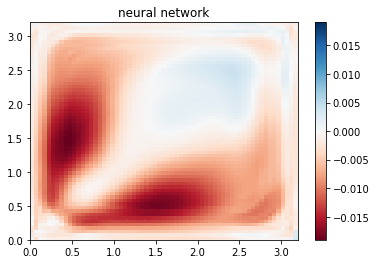

In [144]:
y, x = np.meshgrid(np.linspace(0, ntest*h, soln_chol.shape[-2]), np.linspace(0, ntest*h, soln_chol.shape[-1]))
z = (soln_chol/tf.reduce_max(tf.abs(rhses)))[0,0,...] #cholesky soln
#z = rhses[0,0,...]
#z = (solns/tf.reduce_max(tf.abs(rhses)))[0,0,...] #analytical soln
z = a.predict(tf.expand_dims((rhses/tf.reduce_max(tf.abs(rhses)))[0,...], axis=0))[0,0,...] #nn
#z = a.predict(tf.expand_dims((rhses/tf.reduce_max(tf.abs(rhses)))[0,...], axis=0))[0,0,...] - (solns/tf.reduce_max(tf.abs(rhses)))[0,0,...] #nn - analytical
#z = (soln_chol/tf.reduce_max(tf.abs(rhses)))[0,0,...] - (solns/tf.reduce_max(tf.abs(rhses)))[0,0,...] #chol - analytical
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('neural network')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [31]:
import sys
sys.modules['__main__'].__file__ = 'ipython'

In [6]:
a.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 64, 64)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 5, 64, 64)    50          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 64, 64)   736         conv2d_2[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_7 (AveragePoo (None, 16, 32, 32)   0           conv2d_3[0][0]                   
______________________________________________________________________________________________